In [62]:
import pandas as pd
import numpy as np

user_behavior = pd.read_parquet("../data/processed/user_behavior.parquet", engine="fastparquet")

u = user_behavior.sort_values("n_ratings", ascending=False)

u["cum_ratings_share"] = u["n_ratings"].cumsum() / u["n_ratings"].sum()
u["user_share"] = np.arange(1, len(u) + 1) / len(u)

u.head()

,userId,n_ratings,mean_rating,std_rating,first_rating,last_rating,n_unique_movies,active_days,ratings_per_day,cum_ratings_share,user_share
72314,72315,32202,3.080601,0.744733,2015-12-15 06:59:27+00:00,2019-10-08 10:10:29+00:00,32202,1393,23.100430,0.001288,0.000006
80973,80974,9178,3.280290,0.560175,2001-08-05 18:10:38+00:00,2015-12-24 20:44:49+00:00,9178,5254,1.746527,0.001655,0.000012
137292,137293,8913,3.184001,0.521824,2009-04-07 02:50:08+00:00,2019-11-16 02:06:19+00:00,8913,3874,2.300129,0.002012,0.000018
33843,33844,7919,2.580124,1.057450,2012-12-13 02:21:42+00:00,2019-11-03 16:26:55+00:00,7919,2516,3.146206,0.002328,0.000025
20054,20055,7488,3.208868,0.947946,2006-10-10 06:41:32+00:00,2015-02-12 06:35:57+00:00,7488,3046,2.457499,0.002628,0.000031


In [ ]:
pct_users_50 = u.loc[u["cum_ratings_share"] <= 0.5, "user_share"].max()
pct_users_50

np.float64(0.11486947908527695)

- 11%of users are responsible for 50%of ratings

### Visual 1 — User activity concentration (learning signal dominance)

This curve shows how unevenly rating activity is distributed across users. If a small fraction of users contributes a large share of ratings, a recommender trained on this data will be disproportionately exposed to their behavioral patterns.


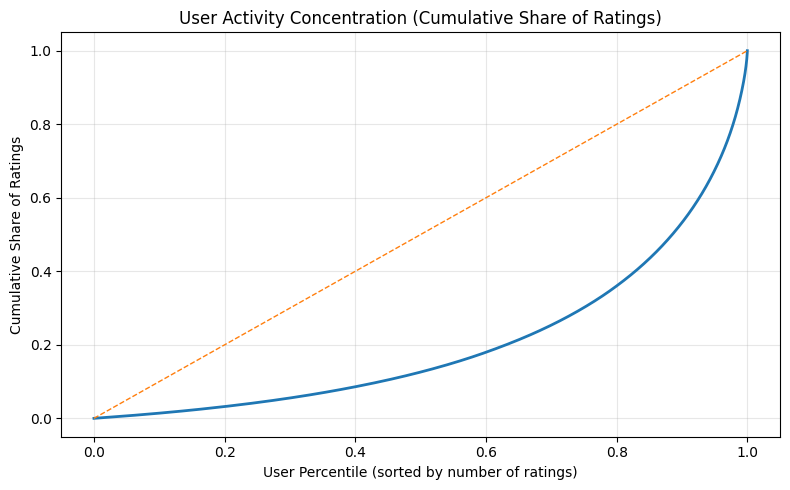

Bottom 90% of users contribute 53.25% of ratings.
Bottom 95% of users contribute 67.50% of ratings.
Bottom 99% of users contribute 87.86% of ratings.


In [104]:
import numpy as np
import matplotlib.pyplot as plt

# --- User dominance curve (cumulative share of ratings by user percentile) ---
x = u["n_ratings"].to_numpy()
x = x[~np.isnan(x)]
x = np.sort(x)

cum_ratings_share = np.cumsum(x) / np.sum(x)
user_percentile = np.arange(1, len(x) + 1) / len(x)

plt.figure(figsize=(8, 5))
plt.plot(user_percentile, cum_ratings_share, linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)  # equality line
plt.title("User Activity Concentration (Cumulative Share of Ratings)")
plt.xlabel("User Percentile (sorted by number of ratings)")
plt.ylabel("Cumulative Share of Ratings")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

for p in [0.90, 0.95, 0.99]:
    idx = int(np.ceil(p * len(x))) - 1
    print(f"Bottom {int(p*100)}% of users contribute {cum_ratings_share[idx]:.2%} of ratings.")

**Interpretation:** User activity is highly concentrated: a small top-tail group generates a disproportionate share of total ratings. This motivates counterfactual tests that remove highly active users to evaluate whether they drive downstream exposure patterns.


# Univariate EDA

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Skewed distribution of user ratings

In [65]:
u.describe()

,userId,n_ratings,mean_rating,std_rating,n_unique_movies,active_days,ratings_per_day,cum_ratings_share,user_share
count,162541.00000,162541.000000,162541.000000,162541.000000,162541.000000,162541.000000,162541.000000,162541.000000,162541.000000
mean,81271.00000,153.807932,3.679205,0.928671,153.807932,221.184581,52.508351,0.794737,0.500003
std,46921.68939,268.047590,0.477368,0.261432,268.047590,716.473199,89.696253,0.213281,0.288676
min,1.00000,20.000000,0.500000,0.000000,20.000000,0.000000,0.005249,0.001288,0.000006
25%,40636.00000,36.000000,3.398747,0.751646,36.000000,0.000000,3.121212,0.698570,0.250005
50%,81271.00000,71.000000,3.700000,0.907605,71.000000,0.000000,29.000000,0.874082,0.500003
75%,121906.00000,162.000000,4.000000,1.084985,162.000000,40.000000,62.000000,0.957037,0.750002
max,162541.00000,32202.000000,5.000000,2.308451,32202.000000,8101.000000,5525.000000,1.000000,1.000000


**User activity is highly right-skewed**: 
- a small fraction of users contribute a disproportionate number of ratings. 
- In contrast, average ratings are tightly clustered around 3.5–4.0, suggesting that differences in user influence arise primarily from volume and variance, rather than systematic generosity or harshness. 

**Rating variance itself is right-skewed**, indicating a minority of users who express preferences more sharply. Additionally, many users exhibit zero active days, implying batch-rating behavior and highlighting limitations of timestamp-based behavioral inference.

# **1. How much of the learning signal is controlled by each activity group?**

In [66]:
u["activity_percentile"] = u["n_ratings"].rank(pct=True)
def assign_activity_group(p):
    if p <= 0.50:
        return "Quiet"
    elif p <= 0.90:
        return "Active"
    elif p <= 0.95:
        return "Power"
    elif p <= 0.99:
        return "Ultra"
    else:
        return "Extreme"
u["activity_group"] = u["activity_percentile"].apply(assign_activity_group)

display(u["activity_group"].value_counts().sort_index())

activity_group
Active     65136
Extreme     1627
Power       8164
Quiet      81119
Ultra       6495
Name: count, dtype: int64

In [67]:
print(f"\nTop 1% of users (Extreme) contribute {u.loc[u['activity_group']=='Extreme', 'n_ratings'].sum() / u['n_ratings'].sum():.2%} of all ratings.")
print(f"Top 5% of users (Extreme + Ultra) contribute {u.loc[u['activity_group'].isin(['Extreme', 'Ultra']), 'n_ratings'].sum() / u['n_ratings'].sum():.2%} of all ratings.")
print(f"Top 10% of users (Extreme + Ultra + Power) contribute {u.loc[u['activity_group'].isin(['Extreme', 'Ultra', 'Power']), 'n_ratings'].sum() / u['n_ratings'].sum():.2%} of all ratings.")
print("-"*80)
print(f"Bottom 50% of users (Quiet) contribute {u.loc[u['activity_group']=='Quiet', 'n_ratings'].sum() / u['n_ratings'].sum():.2%} of all ratings.")


Top 1% of users (Extreme) contribute 12.15% of all ratings.
Top 5% of users (Extreme + Ultra) contribute 32.49% of all ratings.
Top 10% of users (Extreme + Ultra + Power) contribute 46.80% of all ratings.
--------------------------------------------------------------------------------
Bottom 50% of users (Quiet) contribute 12.55% of all ratings.


**User activity is extremely concentrated.**
- The top 1% of users account for 12.15% of all ratings, while the bottom 50% contribute only 12.55%. 
- More broadly, the top 10% of users generate nearly half (46.8%) of the entire dataset. 


This implies that a **recommender system trained on these interactions will disproportionately learn from a small minority of highly active users**, effectively treating their behavioral patterns as representative of the user population.

# **2. Do Ultra/Extreme users disproportionately reinforce already-popular movies?**

If top-tail users disappear, what happens to movie-level structure?

In [68]:
ratings = pd.read_parquet("../data/processed/ratings.parquet", engine="fastparquet")
movies  = pd.read_parquet("../data/processed/movies.parquet", engine="fastparquet")
users   = u.copy()
ratings = ratings[["userId", "movieId", "rating", "rated_at"]]
movies  = movies[["movieId", "title", "genres"]]
users   = users[["userId", "activity_group"]] 

In [69]:
r1 = ratings.merge(users, on="userId", how="left", validate="many_to_one")

In [70]:
missing_group = r1["activity_group"].isna().mean()
missing_group

np.float64(0.0)

In [71]:
df = r1.merge(movies, on="movieId", how="left", validate="many_to_one")

In [72]:
missing_movies = df["title"].isna().mean()
missing_movies

np.float64(0.0)

In [73]:
df["activity_group"] = df["activity_group"].astype("category")

In [74]:
df.to_parquet("../data/processed/ratings_enriched.parquet", index=False, engine="fastparquet")

In [75]:
df.head()

,userId,movieId,rating,rated_at,activity_group,title,genres
0,1,296,5.0,2006-05-17 15:34:04+00:00,Quiet,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,1,306,3.5,2006-05-17 12:26:57+00:00,Quiet,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
2,1,307,5.0,2006-05-17 12:27:08+00:00,Quiet,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
3,1,665,5.0,2006-05-17 15:13:40+00:00,Quiet,Underground (1995),Comedy|Drama|War
4,1,899,3.5,2006-05-17 12:21:50+00:00,Quiet,Singin' in the Rain (1952),Comedy|Musical|Romance


In [76]:
df_all = df.copy()

In [77]:
df_no_top1 = df[df["activity_group"] != "Extreme"]
df_no_top5 = df[~df["activity_group"].isin(["Extreme", "Ultra"])]

In [78]:
def movie_stats(x):
    return (
        x.groupby("movieId")
        .agg(
            n_ratings=("rating", "size"),
            mean_rating=("rating", "mean")
        )
        .reset_index()
    )

movies_all   = movie_stats(df_all)
movies_top1  = movie_stats(df_no_top1)
movies_top5  = movie_stats(df_no_top5)

In [79]:
movies_all["rank_all"]  = movies_all["n_ratings"].rank(ascending=False, method="first")
movies_top1["rank_no1"] = movies_top1["n_ratings"].rank(ascending=False, method="first")
movies_top5["rank_no5"] = movies_top5["n_ratings"].rank(ascending=False, method="first")

In [80]:
compare = (
    movies_all[["movieId", "n_ratings", "rank_all"]]
    .merge(
        movies_top1[["movieId", "rank_no1"]],
        on="movieId",
        how="left"
    )
    .merge(
        movies_top5[["movieId", "rank_no5"]],
        on="movieId",
        how="left"
    )
)

In [81]:
top20_all = compare[compare["rank_all"] <= 20]

top20_all[["rank_all", "rank_no1", "rank_no5"]].head(10)

,rank_all,rank_no1,rank_no5
0,13.0,13.0,12.0
49,15.0,15.0,14.0
108,9.0,9.0,9.0
257,6.0,6.0,6.0
292,3.0,3.0,3.0
314,2.0,1.0,1.0
351,1.0,2.0,2.0
475,7.0,7.0,7.0
522,8.0,8.0,8.0
581,11.0,11.0,11.0


The most popular movies are structurally robust to the removal of a very small elite (top 1%), but become mildly sensitive once a larger share of high-activity users is removed.

Removing the top 1% of users has minimal impact on the most popular movies, indicating that head items are widely preferred across the user base. 

However, removing the top 5% leads to noticeable rank reshuffling among top movies, suggesting that exposure intensity, rather than taste divergence, is sensitive to the presence of highly active users

## How much of the total rating volume goes to tail movies, and how does that changes when top users are removed?
(TES - Tail Exposure Share)

In [82]:
df_all.head()

,userId,movieId,rating,rated_at,activity_group,title,genres
0,1,296,5.0,2006-05-17 15:34:04+00:00,Quiet,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,1,306,3.5,2006-05-17 12:26:57+00:00,Quiet,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
2,1,307,5.0,2006-05-17 12:27:08+00:00,Quiet,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
3,1,665,5.0,2006-05-17 15:13:40+00:00,Quiet,Underground (1995),Comedy|Drama|War
4,1,899,3.5,2006-05-17 12:21:50+00:00,Quiet,Singin' in the Rain (1952),Comedy|Musical|Romance


In [83]:
movies_all["n_ratings_percentile"] = movies_all["n_ratings"].rank(pct=True)
def assign_movie_popularity_group(p):
    if p >= 0.80:
        return "Head"
    else:
        return "Tail"
movies_all["popularity_group"] = movies_all["n_ratings_percentile"].apply(assign_movie_popularity_group)
movies_all["popularity_group"].value_counts()

popularity_group
Tail    47256
Head    11791
Name: count, dtype: int64

In [84]:
print(f"Top 20% of movies (Head) receive {movies_all.loc[movies_all['popularity_group']=='Head', 'n_ratings'].sum() / movies_all['n_ratings'].sum():.2%} of all ratings.")
print(f"Bottom 80% of movies (Tail) receive {movies_all.loc[movies_all['popularity_group']=='Tail', 'n_ratings'].sum() / movies_all['n_ratings'].sum():.2%} of all ratings.")

Top 20% of movies (Head) receive 98.26% of all ratings.
Bottom 80% of movies (Tail) receive 1.74% of all ratings.


In [95]:
movies_top1["n_ratings_percentile"] = movies_top1["n_ratings"].rank(pct=True)
movies_top1["popularity_group"] = movies_top1["n_ratings_percentile"].apply(assign_movie_popularity_group)
print("movies top 1% dropped", movies_top1["popularity_group"].value_counts())

movies_top5["n_ratings_percentile"] = movies_top5["n_ratings"].rank(pct=True)
movies_top5["popularity_group"] = movies_top5["n_ratings_percentile"].apply(assign_movie_popularity_group)
print("\nmovies top 5% dropped", movies_top5["popularity_group"].value_counts())

movies top 1% dropped popularity_group
Tail    35696
Head     8904
Name: count, dtype: int64

movies top 5% dropped popularity_group
Tail    29112
Head     7275
Name: count, dtype: int64


- Highly active users are responsible for keeping a non-trivial number of movies “alive” in the system.

In [98]:
print('='*10, "All movies included", '='*10)
print(f"Top 20% of movies (Head) receive {movies_all.loc[movies_all['popularity_group']=='Head', 'n_ratings'].sum() / movies_all['n_ratings'].sum():.2%} of all ratings.")
print(f"Bottom 80% of movies (Tail) receive {movies_all.loc[movies_all['popularity_group']=='Tail', 'n_ratings'].sum() / movies_all['n_ratings'].sum():.2%} of all ratings.")

print('\n','='*10, "Top 1% users dropped", '='*10)
print(f"Top 20% of movies (Head) receive {movies_top1.loc[movies_top1['popularity_group']=='Head', 'n_ratings'].sum() / movies_top1['n_ratings'].sum():.2%} of all ratings.")
print(f"Bottom 80% of movies (Tail) receive {movies_top1.loc[movies_top1['popularity_group']=='Tail', 'n_ratings'].sum() / movies_top1['n_ratings'].sum():.2%} of all ratings.")

print('\n','='*10, "Top 5% users dropped", '='*10)
print(f"Top 20% of movies (Head) receive {movies_top5.loc[movies_top5['popularity_group']=='Head', 'n_ratings'].sum() / movies_top5['n_ratings'].sum():.2%} of all ratings.")
print(f"Bottom 80% of movies (Tail) receive {movies_top5.loc[movies_top5['popularity_group']=='Tail', 'n_ratings'].sum() / movies_top5['n_ratings'].sum():.2%} of all ratings.")

========== All movies included ==========
Top 20% of movies (Head) receive 98.26% of all ratings.
Bottom 80% of movies (Tail) receive 1.74% of all ratings.

 ========== Top 1% users dropped ==========
Top 20% of movies (Head) receive 98.31% of all ratings.
Bottom 80% of movies (Tail) receive 1.69% of all ratings.

 ========== Top 5% users dropped ==========
Top 20% of movies (Head) receive 98.18% of all ratings.
Bottom 80% of movies (Tail) receive 1.82% of all ratings.


### Visual 2 — Head vs tail exposure share under counterfactual user removal

To test whether highly active users cause popularity bias, I compare the share of rating volume allocated to head (top 20% most-rated movies) versus tail (bottom 80%) across the baseline dataset and counterfactual datasets with top-tail users removed.


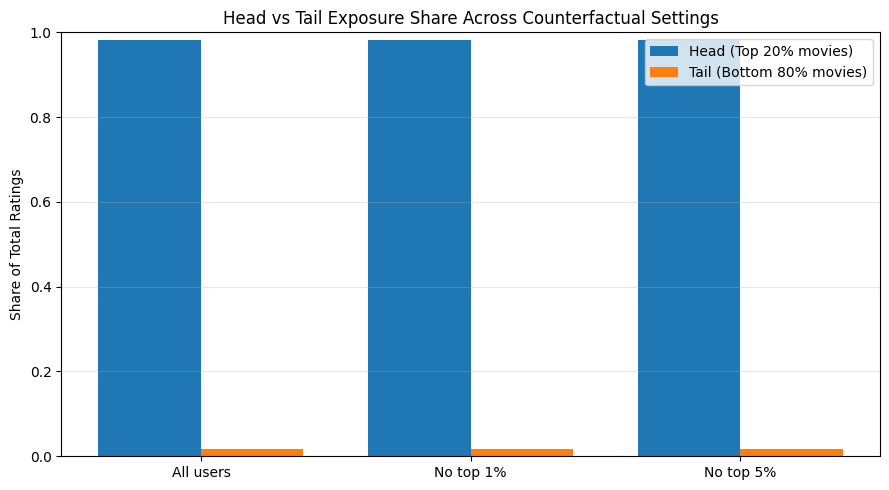

All users: Head=98.26%, Tail=1.74%
No top 1%: Head=98.31%, Tail=1.69%
No top 5%: Head=98.18%, Tail=1.82%


In [103]:
def tail_exposure_share(movies_df, tail_label="Tail"):
    total = movies_df["n_ratings"].sum()
    tail = movies_df.loc[movies_df["popularity_group"] == tail_label, "n_ratings"].sum()
    return tail / total

def head_exposure_share(movies_df, head_label="Head"):
    total = movies_df["n_ratings"].sum()
    head = movies_df.loc[movies_df["popularity_group"] == head_label, "n_ratings"].sum()
    return head / total

labels = ["All users", "No top 1%", "No top 5%"]
head_shares = [
    head_exposure_share(movies_all),
    head_exposure_share(movies_top1),
    head_exposure_share(movies_top5),
]
tail_shares = [
    tail_exposure_share(movies_all),
    tail_exposure_share(movies_top1),
    tail_exposure_share(movies_top5),
]

x = range(len(labels))
bar_width = 0.38

plt.figure(figsize=(9, 5))
plt.bar([i - bar_width/2 for i in x], head_shares, width=bar_width, label="Head (Top 20% movies)")
plt.bar([i + bar_width/2 for i in x], tail_shares, width=bar_width, label="Tail (Bottom 80% movies)")

plt.title("Head vs Tail Exposure Share Across Counterfactual Settings")
plt.xticks(list(x), labels)
plt.ylabel("Share of Total Ratings")
plt.ylim(0, 1.0)
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
for name, h, t in zip(labels, head_shares, tail_shares):
    print(f"{name}: Head={h:.2%}, Tail={t:.2%}")

**Interpretation:** Exposure remains overwhelmingly concentrated on head items (≈98%+) across all settings. Removing the top 1% or even top 5% of users produces only marginal changes in tail exposure share, indicating that head-dominance is largely structural rather than driven by power users alone.


### Visual 3 — Tail survival (catalog coverage) under counterfactual user removal

Even if the aggregate tail exposure share is stable, tail *coverage* may still be sensitive: removing highly active users can reduce the number of tail movies that receive any ratings at all.


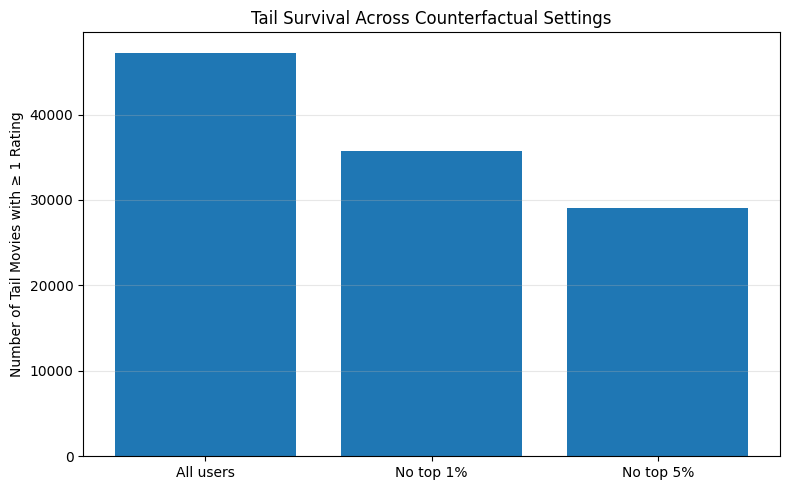

All users: tail movies with ≥1 rating = 47,256
No top 1%: tail movies with ≥1 rating = 35,696
No top 5%: tail movies with ≥1 rating = 29,112


In [106]:
def count_movies_with_any_rating(movies_df):
    return (movies_df["n_ratings"] > 0).sum()

def count_tail_movies_with_any_rating(movies_df):
    tail = movies_df[movies_df["popularity_group"] == "Tail"]
    return (tail["n_ratings"] > 0).sum()

labels = ["All users", "No top 1%", "No top 5%"]
tail_alive = [
    count_tail_movies_with_any_rating(movies_all),
    count_tail_movies_with_any_rating(movies_top1),
    count_tail_movies_with_any_rating(movies_top5),
]

plt.figure(figsize=(8, 5))
plt.bar(labels, tail_alive)
plt.title("Tail Survival Across Counterfactual Settings")
plt.ylabel("Number of Tail Movies with ≥ 1 Rating")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

for name, n in zip(labels, tail_alive):
    print(f"{name}: tail movies with ≥1 rating = {n:,}")


**Interpretation:** Counterfactual removal reduces the number of tail movies that receive any exposure (≥1 rating). This suggests that highly active users help keep parts of the long tail “alive,” even though they do not materially change the overall head–tail exposure split.


---

**Across all counterfactual settings, exposure remains overwhelmingly concentrated on the most popular items: the top 20% of movies consistently receive over 98% of all ratings. Removing the top 1% or even top 5% of users produces only marginal changes in tail exposure share, indicating that long-tail under-exposure is not driven by highly active users but emerges as a structural property of the interaction data itself.**